<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Experiments/5_category_experiments/5_category_shallow_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Long Review Texts, 5 Categories and Shallow Neural Network**

In this experiment, we utilize the long review texts and classify them into 5 categories. As well, a shallower nerual network is used in hopes of lowering the high variance as seen with the complexed initial models.

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 213 kB 75.5 MB/s 
     |████████████████████████████████| 99 kB 11.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 352 kB 72.9 MB/s 
     |████████████████████████████████| 1.1 MB 65.4 MB/s 
     |████████████████████████████████| 1.2 MB 71.5 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 4.3 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11841373125720261692
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9395215849473424151
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

When running this notebook please make sure to follow the steps outlined in the readme file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Below we are loading in the pre-trained BERT model.

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
data_2 = pd.read_pickle('/content/drive/MyDrive/small6.plk')

In [ ]:
data_2.head(500)

,helpful,reviewText,overall,summary
469,"[5, 5]","First, this is a very cute machine. I bought t...",5,"Easy,Fast and FUN!"
532,"[0, 1]",I love this machine. A cousin had tried a cou...,5,Great little machine
796,"[0, 1]",After making the purchase and using a few time...,2,Not For Us - Prefer Electric
955,"[0, 0]",Since I didn't write at least 20 words the fir...,5,What else can one say about Vac Bags?
1039,"[3, 4]",I can only give this a 3. Tools are to small-t...,3,Vacuum Cleaner
...,...,...,...,...
108385,"[1, 1]",It is not quite 8&#34; in diameter and 5&#34; ...,3,Smaller than expected
108715,"[0, 0]","I wanted to like this, I really did. I teach h...",3,So much potential....
108988,"[0, 0]",When the Senseo pods became harder and harder ...,2,Pain in the neck...
109152,"[0, 0]",I GOT THIS FOR MY WIFE SHE NEED A NEW ONE SHE ...,5,SWEET


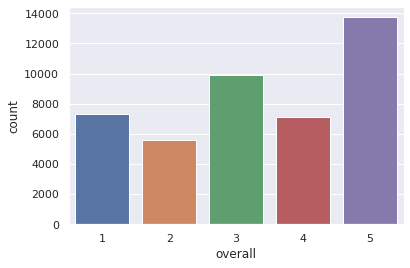

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=data_2)

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43659 entries, 469 to 7589996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     43659 non-null  object
 1   reviewText  43659 non-null  object
 2   overall     43659 non-null  int64 
 3   summary     43659 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
np.random.seed(10)
remove_n = 59
index_to_remove = data_2[data_2.overall == 5].index
drop_indices = np.random.choice(index_to_remove, remove_n, replace=False)
data_2 = data_2.drop(drop_indices)

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43600 entries, 469 to 7589996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     43600 non-null  object
 1   reviewText  43600 non-null  object
 2   overall     43600 non-null  int64 
 3   summary     43600 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
sample_size = int(len(data_2)*0.3)
sampleDf = data_2.sample(sample_size, random_state=23)
x = sampleDf.reviewText.values
y = sampleDf.overall.values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
print(x_train.shape)

(10464,)


In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_val = encoder.transform(y_val)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_val = to_categorical(encoded_Y_val)
dummy_y_train = to_categorical(encoded_Y_train)

The tokenization along with the head+tail tokens selection is done below:

In [ ]:

def encode_names(n):
   tokens = list(tokenizer.tokenize(n)[:127]+tokenizer.tokenize(n)[-381:])
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized reviews shape', reviews.shape.as_list())

Tokenized reviews shape [10464, None]


In [ ]:
x_train[0]

"Don't get me wrong, it does take the makeup right off your face. However as others mentioned, it does leave a thickish film on your face. I've been using the product for only a few days and have noticed tiny pimples that I have in regions where I NEVER break out usually. I'm unsure if it's just a common breakout or if these wipes caused it."

In [ ]:

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
#_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

In [ ]:

input_mask = tf.ones_like(input_word_ids).to_tensor()
#plt.pcolormesh(input_mask)

In [ ]:

type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()
#plt.pcolormesh(input_type_ids)

In [ ]:
lens = [len(i) for i in input_word_ids]
#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [ ]:
#max_seq_length = int(1.5*max_seq_length)
#print('Max length is:', max_seq_length)

In [ ]:

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
max_seq_length = 512


In [ ]:

X_train = bert_encode(x_train, tokenizer, max_seq_length)    
X_val = bert_encode(x_val, tokenizer, max_seq_length)

In [ ]:
epochs = 6 
batch_size = 8 
eval_batch_size = batch_size
LR = 2e-6

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                 


pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  
output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(512, kernel_regularizer= tf.keras.regularizers.L2(0.01), activity_regularizer= tf.keras.regularizers.L1(0.01),activation='relu')(output)
output = tf.keras.layers.Dense(5, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)


In [ ]:
pooled_output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(tfa.optimizers.RectifiedAdam(learning_rate=LR, beta_1= 0.8, beta_2=0.8), # try sgd  
              loss='categorical_crossentropy',
              metrics=['accuracy'],
  
              )

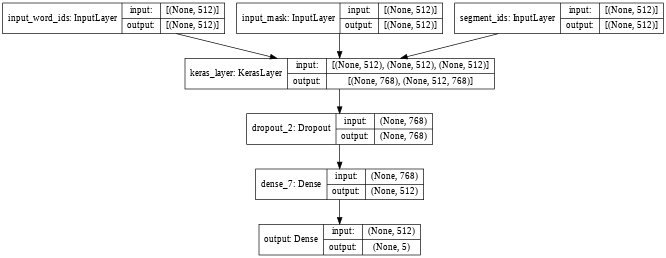

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, dummy_y_test),
                    verbose=1)

Epoch 1/6
1308/1308 [==============================] - 906s 642ms/step - loss: 7.6129 - accuracy: 0.8008 - val_loss: 6.9961 - val_accuracy: 0.8142
Epoch 2/6
1308/1308 [==============================] - 839s 641ms/step - loss: 6.6900 - accuracy: 0.8595 - val_loss: 6.4927 - val_accuracy: 0.8165
Epoch 3/6
1308/1308 [==============================] - 839s 641ms/step - loss: 6.1615 - accuracy: 0.8825 - val_loss: 6.0512 - val_accuracy: 0.8184
Epoch 4/6
1308/1308 [==============================] - 839s 641ms/step - loss: 5.6660 - accuracy: 0.9018 - val_loss: 5.6340 - val_accuracy: 0.8184
Epoch 5/6
1308/1308 [==============================] - 839s 641ms/step - loss: 5.1881 - accuracy: 0.9136 - val_loss: 5.2018 - val_accuracy: 0.8146
Epoch 6/6
1308/1308 [==============================] - 838s 641ms/step - loss: 4.7229 - accuracy: 0.9255 - val_loss: 4.7971 - val_accuracy: 0.8177


In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, dummy_y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9515
Testing Accuracy:  0.8177


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

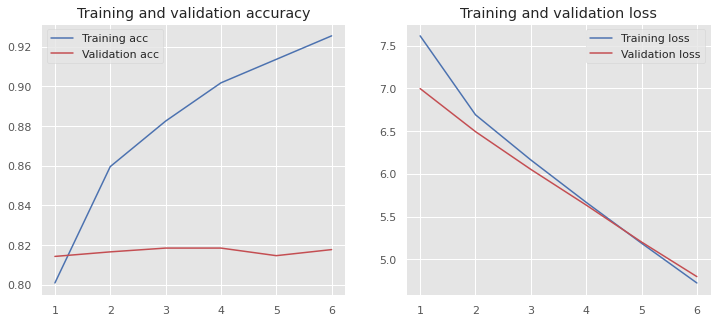

In [ ]:
plot_history(history)

Below, the model saved for thos experiment is loaded in. We also load in more data (that was NOT present in the dataset already loaded in) for testing purposes.

In [ ]:
model_fname = 'Ratings_BERT_7'
my_wd = '/content/drive/My Drive'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_7/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_7/assets


In [ ]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8177


In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

[UNK] [100]
' [1005]
t [1056]
get [2131]
me [2033]
wrong [3308]
, [1010]
it [2009]
does [2515]
take [2202]
the [1996]
makeup [5789]
right [2157]
off [2125]
your [2115]
face [2227]
. [1012]
[UNK] [100]
as [2004]
others [2500]
mentioned [3855]
, [1010]
it [2009]
does [2515]
leave [2681]
a [1037]
thick [4317]
##ish [4509]
film [2143]
on [2006]
your [2115]
face [2227]
. [1012]
[UNK] [100]
' [1005]
ve [2310]
been [2042]
using [2478]
the [1996]
product [4031]
for [2005]
only [2069]
a [1037]
few [2261]
days [2420]
and [1998]
have [2031]
noticed [4384]
tiny [4714]
pi [14255]
##mple [23344]
##s [2015]
that [2008]
[UNK] [100]
have [2031]
in [1999]
regions [4655]
where [2073]
[UNK] [100]
[UNK] [100]
break [3338]
out [2041]
usually [2788]
. [1012]
[UNK] [100]
' [1005]
m [1049]
unsure [12422]
if [2065]
it [2009]
' [1005]
s [1055]
just [2074]
a [1037]
common [2691]
breakout [25129]
or [2030]
if [2065]
these [2122]
wipe [13387]
##s [2015]
caused [3303]
it [2009]
. [1012]


In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
merged = pd.read_pickle('/content/drive/MyDrive/model 14/model_14_merged_data')

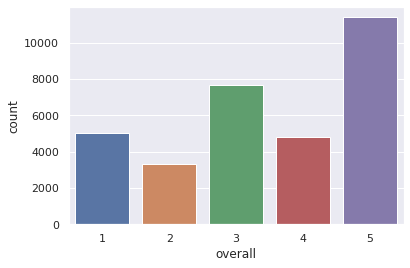

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=merged)

In [ ]:
# getting the 1's 
np.random.seed(10)
get_n = 2400
index_to_get = merged[merged.overall == 1].index
get_indices_a = np.random.choice(index_to_get, get_n, replace=False)
data_a = merged.loc[get_indices_a]


# getting the 2's
np.random.seed(10)
get_n = 2400
index_to_get = merged[merged.overall == 2].index
get_indices_b = np.random.choice(index_to_get, get_n, replace=False)
data_b = merged.loc[get_indices_b]

# getting the 3's
np.random.seed(10)
get_n = 2400
index_to_get = merged[merged.overall == 3].index
get_indices_c = np.random.choice(index_to_get, get_n, replace=False)
data_c = merged.loc[get_indices_c]

# getting the 4's 
np.random.seed(10)
get_n = 2400
index_to_get = merged[merged.overall == 4].index
get_indices_d = np.random.choice(index_to_get, get_n, replace=False)
data_d = merged.loc[get_indices_d]

# getting the 5's
np.random.seed(10)
get_n = 2400
index_to_get = merged[merged.overall == 5].index
get_indices_e = np.random.choice(index_to_get, get_n, replace=False)
data_e = merged.loc[get_indices_e]

In [ ]:
drop_indicies = np.concatenate((get_indices_a,get_indices_b,get_indices_c,get_indices_d,get_indices_e),axis=0)
merged = merged.drop(drop_indicies, axis=0)

In [ ]:
new_data = pd.concat([data_a, data_b, data_c, data_d, data_e])

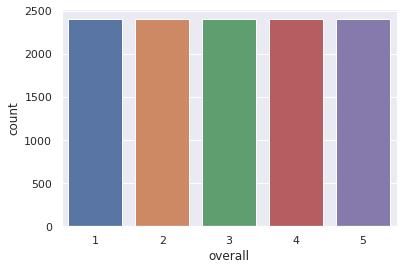

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=new_data)

In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
new_data = shuffle(new_data)
new_data.reset_index(inplace=True, drop=True)

In [ ]:
import sklearn


x_test = new_data.reviewText.values
y_test = new_data.overall.values



In [ ]:
#need to do the encoding (text-preprocessing)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_test)

encoded_Y_test = encoder.transform(y_test)
dummy_y_test = to_categorical(encoded_Y_test)


In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs
  
  

In [ ]:
max_seq_length = 512

In [ ]:
 
X_test = bert_encode(x_test, tokenizer, max_seq_length)


In [ ]:
model_fname = 'Ratings_BERT_7'
my_wd = '/content/drive/My Drive'

In [ ]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
import tensorflow_addons as tfa
new_model.compile(tfa.optimizers.RectifiedAdam(learning_rate= 1e-5, beta_1= 0.8, beta_2=0.8),   
              loss='categorical_crossentropy',
              metrics=['accuracy'],
  
              )

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = new_model.predict(X_test, batch_size=1, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y_test, y_pred_bool, labels=[1,2,3,4,5], digits=4))


12000/12000 [==============================] - 343s 29ms/step
              precision    recall  f1-score   support

           1     0.7975    0.7629    0.7798      2400
           2     0.6896    0.6108    0.6478      2400
           3     0.6461    0.7362    0.6882      2400
           4     0.7127    0.6254    0.6662      2400
           5     0.7625    0.8696    0.8125      2400

    accuracy                         0.7210     12000
   macro avg     0.7217    0.7210    0.7189     12000
weighted avg     0.7217    0.7210    0.7189     12000



In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7210
